In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()

RAW_PATH = PROJECT_ROOT / "data" / "raw" / "venue_weekly_data.csv"
TEST_PATH = PROJECT_ROOT / "data" / "processed" / "test_predictions_with_staffing.csv"
FUTURE_PATH = PROJECT_ROOT / "data" / "processed" / "future_forecasts_with_staffing.csv"

plt.style.use("default")


In [2]:
raw = pd.read_csv(RAW_PATH, parse_dates=["date"])
test = pd.read_csv(TEST_PATH, parse_dates=["date"])
future = pd.read_csv(FUTURE_PATH, parse_dates=["date"])

raw.head(), test.head(), future.head()


(        date venue_id   revenue  staff_hours  weather_score  local_event  \
 0 2023-01-01       V1  21361.14         41.6            1.0            0   
 1 2023-01-08       V1  21838.37         44.5            0.0            0   
 2 2023-01-15       V1  24928.63         45.2            1.0            0   
 3 2023-01-22       V1  19483.45         38.4            0.5            0   
 4 2023-01-29       V1  21886.53         36.6            1.0            0   
 
    promotion  opening_hours  week_of_year  
 0          0             80            52  
 1          1             83             1  
 2          1             87             2  
 3          0             86             3  
 4          0             89             4  ,
         date venue_id   revenue  staff_hours  predicted_revenue  \
 0 2024-08-11       V4  29624.09         59.0       28070.520338   
 1 2024-08-11       V2  30329.02         59.9       30480.418115   
 2 2024-08-11       V3  34623.56         70.2       33096.584

### Overview by venue

This table gives a high-level view of performance and model behaviour per venue.

In [3]:
summary_by_venue = (
    test.groupby("venue_id")
    .agg(
        n_weeks=("date", "nunique"),
        avg_revenue=("revenue", "mean"),
        avg_predicted_revenue=("predicted_revenue", "mean"),
        avg_staff_hours=("staff_hours", "mean"),
    )
    .round(2)
    .sort_values("avg_revenue", ascending=False)
)

summary_by_venue


,n_weeks,avg_revenue,avg_predicted_revenue,avg_staff_hours
venue_id,,,,
V4,21,28322.02,27811.74,56.18
V3,21,28274.29,28109.70,56.38
V1,20,25606.70,25745.55,51.73
V2,21,24931.16,25189.82,50.30
V5,21,19081.15,19996.26,39.41


### Effect of promotions and events

This section looks at how promotions and local events relate to average weekly revenue.

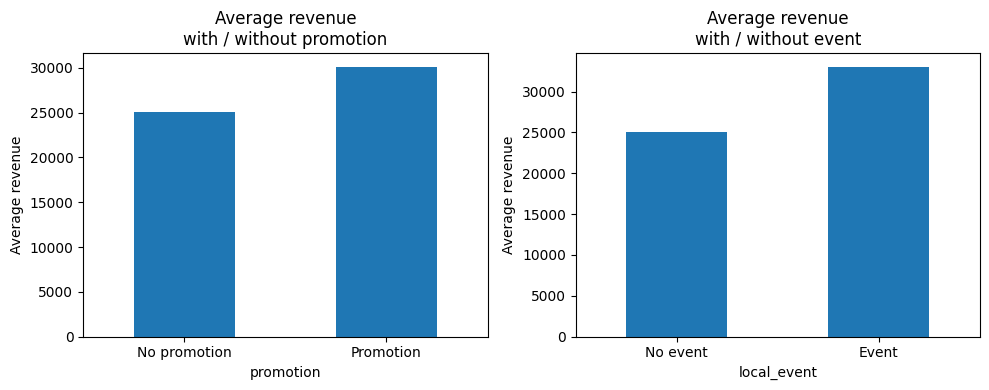

In [4]:
promo_effect = (
    raw.groupby("promotion")["revenue"]
    .mean()
    .rename(index={0: "No promotion", 1: "Promotion"})
    .round(2)
)

event_effect = (
    raw.groupby("local_event")["revenue"]
    .mean()
    .rename(index={0: "No event", 1: "Event"})
    .round(2)
)

promo_effect, event_effect

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
promo_effect.plot(kind="bar")
plt.title("Average revenue\nwith / without promotion")
plt.ylabel("Average revenue")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
event_effect.plot(kind="bar")
plt.title("Average revenue\nwith / without event")
plt.ylabel("Average revenue")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()



### Model performance by venue

This shows how accurate the model is for each venue, using mean absolute percentage error (MAPE).

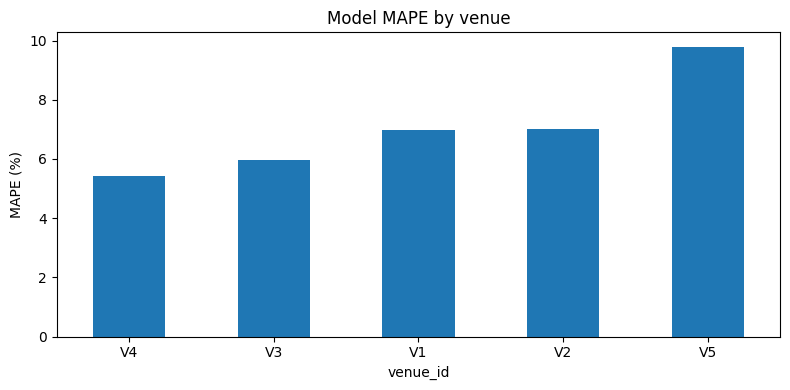

In [5]:
perf_by_venue = (
    test.assign(
        abs_pct_error=lambda d: (d["revenue"] - d["predicted_revenue"]).abs()
        / (d["revenue"].abs() + 1e-6)
    )
    .groupby("venue_id")["abs_pct_error"]
    .mean()
    .mul(100)
    .round(2)
    .rename("MAPE_percent")
    .sort_values()
)

perf_by_venue

plt.figure(figsize=(8, 4))
perf_by_venue.plot(kind="bar")
plt.title("Model MAPE by venue")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Staffing comparison

This section compares actual staff hours with the suggested values from the model-based rule of thumb.

Positive gaps suggest potential overstaffing, negative gaps suggest potential understaffing.

In [7]:
test_with_gap = test.copy()
test_with_gap["staff_gap"] = (
    test_with_gap["staff_hours"] - test_with_gap["suggested_staff_hours_centre"]
)

staff_gap_summary = (
    test_with_gap.groupby("venue_id")["staff_gap"]
    .agg(["mean", "min", "max"])
    .round(2)
    .rename(columns={"mean": "avg_gap", "min": "min_gap", "max": "max_gap"})
    .sort_values("avg_gap")
)

staff_gap_summary

top_over = (
    test_with_gap.sort_values("staff_gap", ascending=False)
    .loc[:, ["date", "venue_id", "revenue", "staff_hours", "suggested_staff_hours_centre", "staff_gap"]]
    .head(10)
)

top_under = (
    test_with_gap.sort_values("staff_gap", ascending=True)
    .loc[:, ["date", "venue_id", "revenue", "staff_hours", "suggested_staff_hours_centre", "staff_gap"]]
    .head(10)
)

top_over, top_under


(          date venue_id   revenue  staff_hours  suggested_staff_hours_centre  \
 53  2024-10-20       V3  27916.52         63.9                          57.7   
 86  2024-12-08       V3  25604.94         58.4                          53.2   
 95  2024-12-22       V4  26261.04         54.8                          49.7   
 100 2024-12-29       V2  22743.78         49.7                          45.1   
 8   2024-08-18       V4  34706.59         71.3                          66.8   
 80  2024-12-01       V1  24567.62         50.9                          46.5   
 81  2024-12-01       V4  28350.53         59.0                          54.7   
 30  2024-09-22       V3  29709.79         64.8                          60.7   
 2   2024-08-11       V3  34623.56         70.2                          66.2   
 37  2024-09-29       V5  24159.25         48.2                          44.3   
 
      staff_gap  
 53         6.2  
 86         5.2  
 95         5.1  
 100        4.6  
 8          4.5  

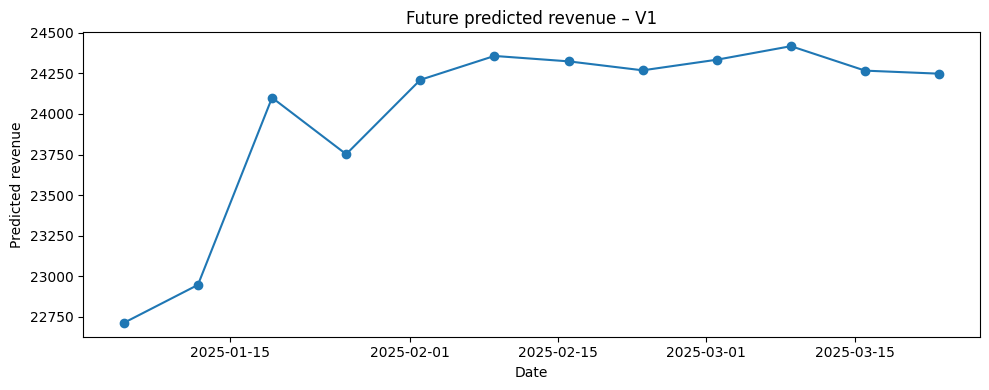

In [8]:
future_summary = (
    future.groupby("venue_id")
    .agg(
        weeks=("date", "nunique"),
        avg_future_revenue=("predicted_revenue", "mean"),
        avg_future_staff=("suggested_staff_hours_centre", "mean"),
    )
    .round(2)
    .sort_values("avg_future_revenue", ascending=False)
)

future_summary

venue_example = future["venue_id"].unique()[0]
future_venue = future[future["venue_id"] == venue_example].sort_values("date")

plt.figure(figsize=(10, 4))
plt.plot(future_venue["date"], future_venue["predicted_revenue"], marker="o")
plt.title(f"Future predicted revenue – {venue_example}")
plt.xlabel("Date")
plt.ylabel("Predicted revenue")
plt.tight_layout()
plt.show()
